<a href="https://colab.research.google.com/github/fleminpaul/MachineLearning/blob/main/CNN_Ninja_Cart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=5b39403e-bf4e-4a93-acba-e5b5b5abcdda
To: /content/ninjacart_data.zip
100% 275M/275M [00:05<00:00, 50.9MB/s]


In [2]:
!unzip ninjacart_data.zip

Archive:  ninjacart_data.zip
   creating: ninjacart_data/test/
   creating: ninjacart_data/test/indian market/
  inflating: ninjacart_data/test/indian market/bhl.jpeg  
  inflating: ninjacart_data/test/indian market/bhv.jpeg  
  inflating: ninjacart_data/test/indian market/bn.jpeg  
  inflating: ninjacart_data/test/indian market/hjx.jpeg  
  inflating: ninjacart_data/test/indian market/igis.jpeg  
  inflating: ninjacart_data/test/indian market/in.jpeg  
  inflating: ninjacart_data/test/indian market/india-4898453__340.jpg  
  inflating: ninjacart_data/test/indian market/indianmarket10.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket12.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket13.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket14.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket15.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket18.jpeg  
  inflating: ninjacart_data/test/indian market/indianmar

In [3]:
!pip install split-folders

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import glob
import tensorflow as tf
from tensorflow import keras # this allows <keras.> instead of <tf.keras.>
tf.keras.utils.set_random_seed(111) # set random seed
import splitfolders
# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 14})

In [5]:
# Split the dataset into train and validation sets
splitfolders.ratio("ninjacart_data/train/", output="ninjacart_data_split", seed=123, ratio=(.8, .2))


Copying files: 3135 files [00:01, 1717.87 files/s]


In [6]:
# # Get a batch of images and labels from the train_ds dataset
# image_batch, labels_batch = next(iter(train_ds))

# # Display 9 images from the batch
# plt.figure(figsize=(10, 10))
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     # Convert the images from normalized [0, 1] to [0, 255] for proper display
#     plt.imshow((image_batch[i].numpy() * 255).astype("uint8"))  # Rescale back to 0-255 range
#     plt.title(train_data.class_names[labels_batch[i]])  # Get class name from labels_batch
#     plt.axis("off")

# plt.show()

In [7]:
class_dirs = os.listdir("ninjacart_data/train/") # list all directories inside "train" folder
image_dict = {} # dict to store image array(key) for every class(value)
count_dict = {} # dict to store count of files(key) for every class(value)
# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'ninjacart_data/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

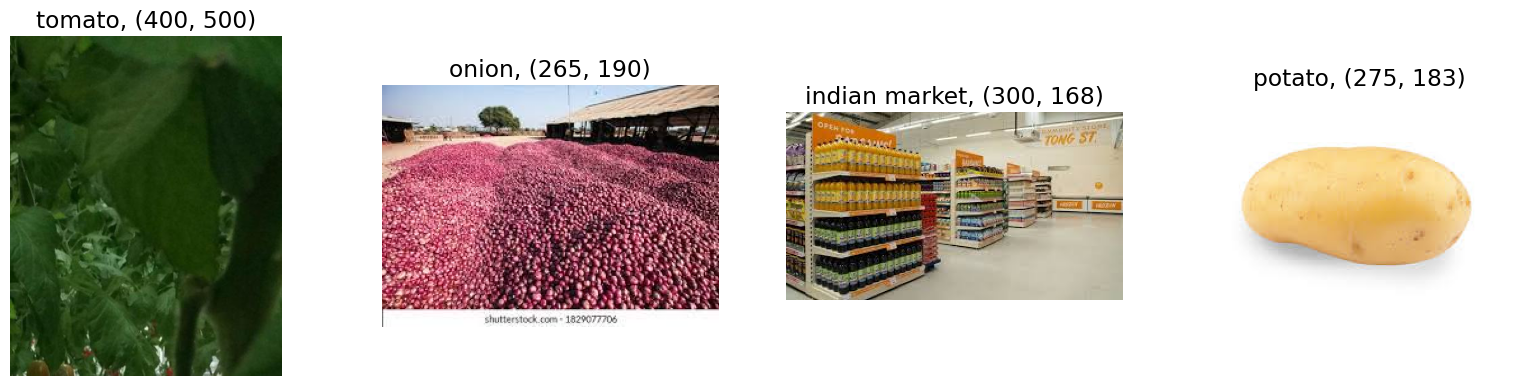

In [8]:
## Viz Random Sample from each class

plt.figure(figsize=(20, 15))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()):
    # create a subplot axis
    ax = plt.subplot(3, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

Count of training samples per class:
            class  count
0         tomato    789
1          onion    849
2  indian market    599
3         potato    898


<Axes: title={'center': 'Training Data Count per class'}, xlabel='class'>

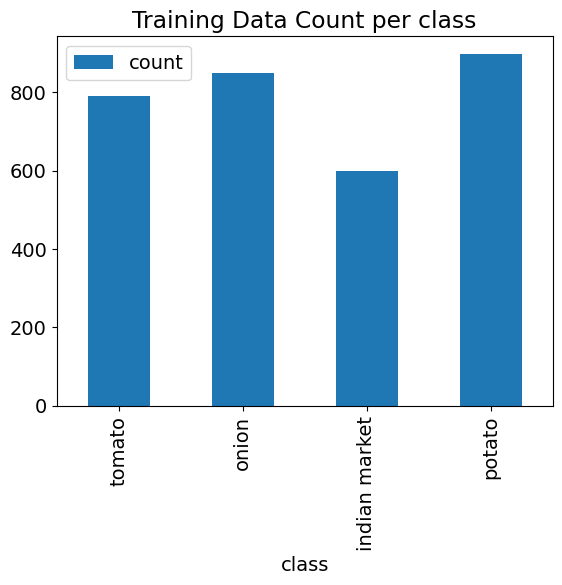

In [9]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

# draw a bar plot using pandas in-built plotting function
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class")

In [10]:
BATCH_SIZE = 128
tf.random.set_seed(10)
np.random.seed(10)
train_ds = tf.keras.utils.image_dataset_from_directory("ninjacart_data_split/train/",shuffle =True, seed=123,image_size=(224, 224),batch_size=BATCH_SIZE)
val_ds   = tf.keras.utils.image_dataset_from_directory("ninjacart_data_split/val/",shuffle =False, seed=123,image_size=(224, 224),batch_size=BATCH_SIZE)
test_ds = tf.keras.utils.image_dataset_from_directory("ninjacart_data/test/",shuffle =False, seed=123,image_size=(224, 224),batch_size=BATCH_SIZE)

data_preprocess = tf.keras.Sequential(
    name="data_preprocess",
    layers=[ tf.keras.layers.Rescaling(1.0/255),]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_ds.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_ds.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_ds.map(lambda x, y: (data_preprocess(x), y))

Found 2507 files belonging to 4 classes.
Found 628 files belonging to 4 classes.
Found 351 files belonging to 4 classes.


In [11]:
def build_model():

    mobilenet_model = tf.keras.applications.MobileNetV2(
        weights ='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

    #Freezing the pretrained mobilenet layers except the last  layer
    # Known as fintuning the model

    for layer in mobilenet_model.layers[:-2]:
        layer.trainable = False


    # for layer in mobilenet_model.layers:
    #     layer.trainable = False


    #Output of base model
    x = mobilenet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation = "relu")(x)
    x = tf.keras.layers.Dense(32, activation = "relu")(x)
    output = tf.keras.layers.Dense(4, activation = 'sigmoid')(x)
    pretrained_model = tf.keras.Model(inputs = mobilenet_model.input, outputs = output)

    return pretrained_model

In [12]:
finetuned_mobilenet = build_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
# Visualizing our model layers and parameters
finetuned_mobilenet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,426,212 (9.26 MB)

 Trainable params: 170,788 (667.14 KB)

 Non-trainable params: 2,255,424 (8.60 MB)

In [14]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cnn_classifier.keras", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True
)

In [15]:
METRICS = [
  tf.keras.metrics.SparseCategoricalAccuracy(),
  # tf.keras.metrics.Precision(name="precision"),
  # tf.keras.metrics.Recall(name="recall"),
  ]

In [16]:
finetuned_mobilenet = build_model()

finetuned_mobilenet.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss= tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics = METRICS
  )

history = finetuned_mobilenet.fit(
  train_ds,
  epochs = 5,
  validation_data = val_ds,
  callbacks=[checkpoint_cb,early_stopping_cb]
  )

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 188s 9s/step - loss: 0.8366 - sparse_categorical_accuracy: 0.6383 - val_loss: 0.2125 - val_sparse_categorical_accuracy: 0.9395
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 211s 11s/step - loss: 0.0884 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.2379 - val_sparse_categorical_accuracy: 0.9347
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 216s 8s/step - loss: 0.0406 - sparse_categorical_accuracy: 0.9856 - val_loss: 0.1273 - val_sparse_categorical_accuracy: 0.9666
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 210s 9s/step - loss: 0.0218 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.1344 - val_sparse_categorical_accuracy: 0.9650
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 184s 9s/step - loss: 0.0140 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.1742 - val_sparse_categorical_accuracy: 0.9570


In [17]:
finetuned_mobilenet.evaluate(test_ds, return_dict=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 0.4934 - sparse_categorical_accuracy: 0.8473


{'loss': 0.3684968948364258, 'sparse_categorical_accuracy': 0.8860399127006531}

In [18]:
history.history

{'loss': [0.4869897961616516,
  0.0812174528837204,
  0.03604654595255852,
  0.01948670856654644,
  0.014563172124326229],
 'sparse_categorical_accuracy': [0.8137215971946716,
  0.9724770784378052,
  0.9880335330963135,
  0.9968089461326599,
  0.9980055689811707],
 'val_loss': [0.21254876255989075,
  0.23787647485733032,
  0.1273137778043747,
  0.13440759479999542,
  0.17423845827579498],
 'val_sparse_categorical_accuracy': [0.9394904375076294,
  0.9347133636474609,
  0.9665604829788208,
  0.9649681448936462,
  0.9570063948631287]}

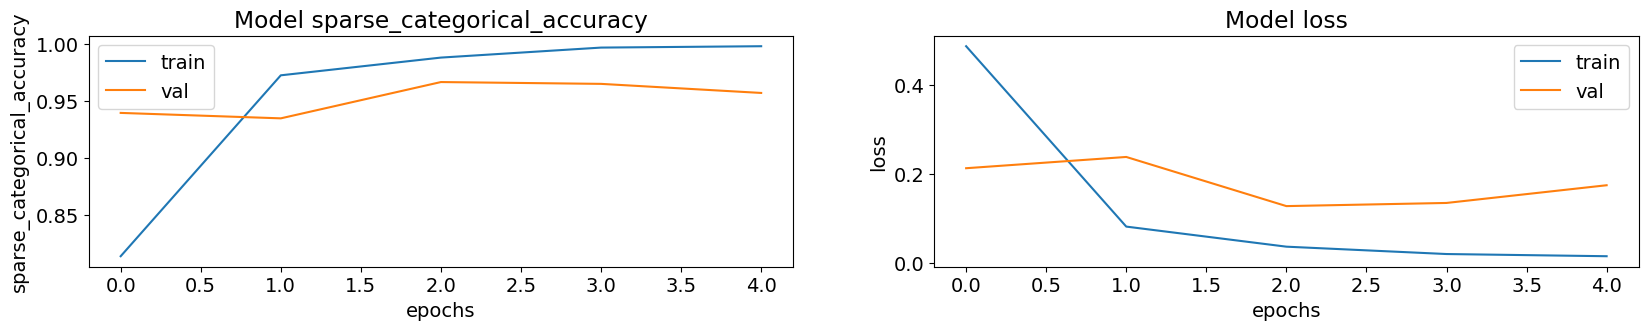

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate([ "sparse_categorical_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [20]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

In [21]:
# Evaluate the model
loss, acc = finetuned_mobilenet.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

3/3 - 20s - 7s/step - loss: 0.3685 - sparse_categorical_accuracy: 0.8860
Restored model, accuracy: 88.60%


In [22]:
def plot_image(pred_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ".format(predicted_label,
                                100*np.max(pred_array),
                                ),
                                color=color)

3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step


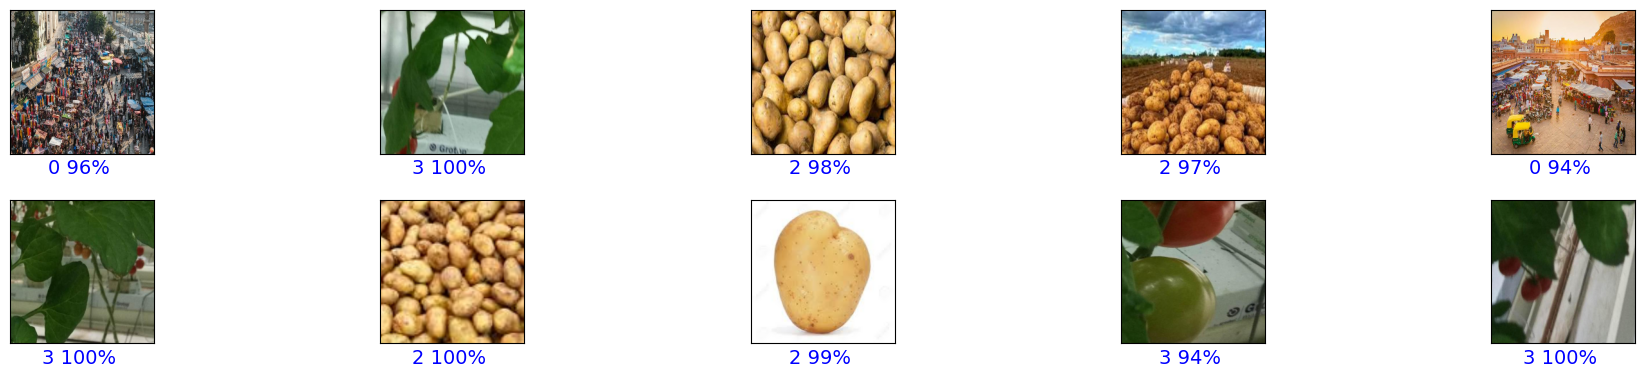

In [23]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = finetuned_mobilenet.predict(test_ds)
# class_names = test_ds.class_names

# Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
indices = random.sample(range(len(images)), 10)
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 2
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(4*num_cols, 2*num_rows))
for i,index in enumerate(indices):
  plt.subplot(num_rows, num_cols, i+1)
  plot_image(y_pred[index], true_categories[index], images[index])

plt.tight_layout()
plt.show()

In [24]:
def build_vgg16_model():

    vgg16_model = tf.keras.applications.VGG16(
        weights ='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

    #Freezing the pretrained mobilenet layers except the last  layer
    # Known as fintuning the model

    for layer in vgg16_model.layers[:-2]:
        layer.trainable = False


    # for layer in mobilenet_model.layers:
    #     layer.trainable = False


    #Output of base model
    x = vgg16_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation = "relu")(x)
    x = tf.keras.layers.Dense(32, activation = "relu")(x)
    output = tf.keras.layers.Dense(4, activation = 'sigmoid')(x)
    pretrained_model = tf.keras.Model(inputs = vgg16_model.input, outputs = output)

    return pretrained_model

In [25]:
finetuned_vgg16 = build_vgg16_model()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [26]:
# Visualizing our model layers and parameters
finetuned_vgg16.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          65,6

 Total params: 14,784,612 (56.40 MB)

 Trainable params: 2,429,732 (9.27 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [27]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cnn_classifier_vgg16.keras", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True
)

In [28]:
METRICS = [
  tf.keras.metrics.SparseCategoricalAccuracy(),
  # tf.keras.metrics.Precision(name="precision"),
  # tf.keras.metrics.Recall(name="recall"),
  ]

In [ ]:
finetuned_vgg16 = build_vgg16_model()

finetuned_vgg16.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss= tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics = METRICS
  )

history = finetuned_vgg16.fit(
  train_ds,
  epochs = 5,
  validation_data = val_ds,
  callbacks=[checkpoint_cb,early_stopping_cb]
  )

Epoch 1/5
 3/20 ━━━━━━━━━━━━━━━━━━━━ 23:00 81s/step - loss: 1.4532 - sparse_categorical_accuracy: 0.3234

In [ ]:
finetuned_vgg16.evaluate(test_ds, return_dict=True)

In [ ]:
history.history

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate([ "sparse_categorical_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [ ]:
# Evaluate the model
loss, acc = finetuned_vgg16.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
def plot_image(pred_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ".format(predicted_label,
                                100*np.max(pred_array),
                                ),
                                color=color)

In [ ]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = finetuned_vgg16.predict(test_ds)
# class_names = test_ds.class_names

# Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
indices = random.sample(range(len(images)), 10)
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 2
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(4*num_cols, 2*num_rows))
for i,index in enumerate(indices):
  plt.subplot(num_rows, num_cols, i+1)
  plot_image(y_pred[index], true_categories[index], images[index])

plt.tight_layout()
plt.show()

In [ ]:
'''
# Trained VGG16 and MobileNet

# For VGG16
Total params: 14,784,612 (56.40 MB)
Trainable params: 2,429,732 (9.27 MB)
Non-trainable params: 12,354,880 (47.13 MB)
Trained with Sparse categorical entropy with 89% accuracy

# For MobileNet
Total params: 2,426,212 (9.26 MB)
Trainable params: 170,788 (667.14 KB)
Non-trainable params: 2,255,424 (8.60 MB)
Trained with Sparse categorical entropy with 80% accuracy


Training in VGG16 is verymuch slow compared to MobileNet.
Accuracy is less compared to MobileNet
'''